In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random #generating negative random numbers

from mpl_toolkits.mplot3d import Axes3D # for 3D visualization


## Dendpoint generation in 2D

In [2]:
Ldend = 180
soma = np.zeros(3)
soma= np.array([-150,-300,0])

DEBUG=False

def debug_print(*s):
    if DEBUG:
        print(*s)
    else:
        pass

def make_random_dend_ends():
    angle0 = np.random.rand()*np.pi/2
    debug_print("Starting Point",angle0) #random starting point
    # first 3 angles between dends
    angles3 = np.ones(3)*np.pi/2
    angles = np.cumsum(angles3) 
    angles = np.hstack([0, angles]) + angle0 

    #adding more variability for each point independent from the others
    r=np.random.uniform(-0.5, 0.5,4)
    angles=angles+r
    debug_print("Single Point Variation=", r)

    #produce x and y coordinates
    return np.array([[Ldend*np.cos(a), Ldend*np.sin(a)] for a in angles]) # cos=x; sin=y
    
point1_xz = make_random_dend_ends()               
print(point1_xz)

print(soma)
point1_xz = point1_xz + soma[:2]               

print(point1_xz)




[[ 174.35295877   44.73305008]
 [ -44.90815504  174.30793904]
 [-120.61639669 -133.6101974 ]
 [ 126.62759425 -127.92752782]]
[-150 -300    0]
[[  24.35295877 -255.26694992]
 [-194.90815504 -125.69206096]
 [-270.61639669 -433.6101974 ]
 [ -23.37240575 -427.92752782]]


In [3]:
#circle
theta = np.linspace( 0 , 2 * np.pi , 170 )  
radius = Ldend #ToDO automate: point -soma?
Ca = radius * np.cos( theta )+soma[0]
Cb = radius * np.sin( theta )+soma[1]

In [4]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-500,150,150)
upperLimit=-250 #MLI layer border
lowerLimit=-75 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

In [5]:
##Check if upper layer limit collides with dendrite radius around soma
#calculate distance between layer and soma
d=abs(soma[1]-upperLimit)
print(d)
if d < radius:
    print("Dendrites might interfere with layer limit")
elif d <= radius:
    print("Dendrites might reach layer limit")
else:
    print("There is enough space for dendrites")



50
Dendrites might interfere with layer limit


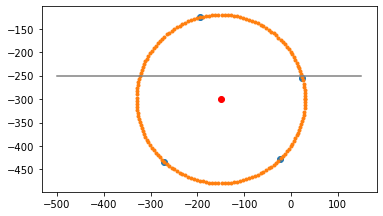

In [6]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
axes.plot(soma[0],soma[1], 'or')

axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

In [7]:
#check which dendrite is outside of the layer and correct its position
def fix_dend_ends_upper(point1_xz, soma, upperLimit, push_down=100):
    
    d=abs(soma[1]-upperLimit)
    
    point1_xz_new = np.zeros_like(point1_xz)
    for i in range(point1_xz.shape[0]):
        x, y=point1_xz[i];
        
        #print(point1_xz[i]);
        if y>soma[1]+d:
            debug_print("Dendrite",i, "is outside the layer:", point1_xz[i]);
            if point1_xz[i,0]< soma[0]:       # make sure each dendrite goes to one one side
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer+ variability 
                point1_xz_new[i,1]=y
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,0]=soma[0]-(x1-soma[0]) 
            else:
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,:]=[x1, y]
            debug_print("New Coordinates", point1_xz[i])
        else:
            debug_print("Dendrite",i, "is inside the layer ")
            point1_xz_new[i,:]= [x, y]

    return point1_xz_new


point1_xz_new = fix_dend_ends_upper(point1_xz, soma, -250)

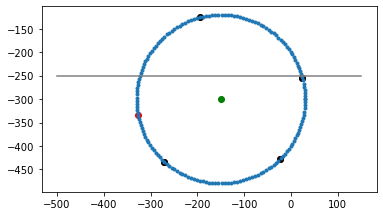

In [8]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz_new[:,0], point1_xz_new[:,1], 'or')
axes.plot(point1_xz[:,0], point1_xz[:,1], 'ok')
axes.plot(soma[0],soma[1], 'og')
axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

Add points between Soma and EndPoint

In [9]:
#calculate x values for points between soma and endpoint
#xDendAll=np.empty((0,0), dtype=object)
def dend_points_soma_endpoint(point1_xz_new, soma, nPoint=90):
    xDendAll = np.zeros(shape=(0))
    yDendAll = np.zeros(shape=(0))
    for i in range(point1_xz_new.shape[0]):
        #nPoint= 90
        xLen=abs(soma[0]-point1_xz_new[i,0]) # length of dendrite on x axis
        xComp= xLen/nPoint # distance of compartments on x axis
        if point1_xz_new[i,0] < soma[0]:
            xDend=(np.cumsum(np.ones(nPoint-1)*xComp))+ point1_xz_new[i,0]#soma[0]
            xDendAll = np.append(xDendAll, xDend, axis=0)
        else:
            xDend=(np.cumsum(np.ones(nPoint-1)*xComp))+soma[0]
            xDendAll = np.append(xDendAll, xDend, axis=0)
        #calculating slope
        m=(soma[1]-point1_xz_new[i,1])/(soma[0]-point1_xz_new[i,0]) #m=(y1-y2)/(x1-x2)
        #function for calculating y
        yDend=np.array((m*xDend)-(m*soma[0])+soma[1])
        
        yDendAll = np.append(yDendAll, yDend, axis=0)
    
    return xDendAll, yDendAll
        
xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)


#TODO: case for vertical line?

    


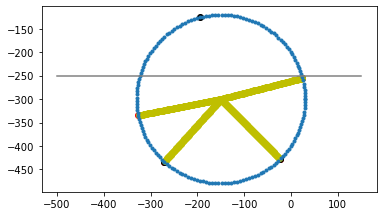

In [10]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz_new[:,0], point1_xz_new[:,1], 'or')
axes.plot(point1_xz[:,0], point1_xz[:,1], 'ok')
axes.plot(soma[0],soma[1], 'og')
axes.plot(xDendAll[:],yDendAll[:],'oy')
axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

ADD MORE SOMA

In [11]:
soma = np.zeros((60,3))
somas = np.array([np.random.uniform(-600,600,3) for i in soma]) # cos=x; sin=y
somas[:,0] = np.random.uniform(-600, 600, size=60)
somas[:,1] = np.random.uniform(20, 180, size=60)


print("We generated", len(somas), "somas.")

We generated 60 somas.


In [12]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-600,600,600)
upperLimit=max(somas[:,1])+20 #MLI layer border
lowerLimit=min(somas[:,1]-20) #MLI layer border

#upperLimit= 200 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

In [13]:
lowerLimit

1.1254492212606593

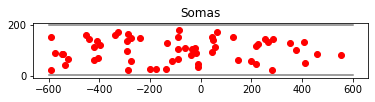

In [14]:
figure, axes= plt.subplots(1)

#axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
#axes.plot(Ca,Cb, ".")
axes.plot(somas[:,0],somas[:,1] ,'or')
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas");

In [15]:
##generate endpoints around respective somas
EpointDendx=np.empty((0,2), dtype=object) #empty array for dendrites
EpointDend=np.empty((0,2), dtype=object) #empty array for dendrites
xDendAllAll=np.empty((0), dtype=object) #empty array for dendrites
yDendAllAll=np.empty((0), dtype=object) #empty array for dendrites

for s in range(somas.shape[0]):
    
    soma = somas[s,:2]
    point1_xz = make_random_dend_ends() + soma
    point1_xz_new = fix_dend_ends_upper(point1_xz, soma, upperLimit)
    point1_xz_new = -fix_dend_ends_upper(-point1_xz_new, -soma, lowerLimit)
    xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)
    

    
    EpointDendx = np.append(EpointDendx, point1_xz, axis=0)
    EpointDend = np.append(EpointDend, point1_xz_new, axis=0)
    
    xDendAllAll = np.append(xDendAllAll, xDendAll, axis=0)
    yDendAllAll = np.append(yDendAllAll, yDendAll, axis=0)

In [16]:
point1_xz

array([[-321.47936116,  282.4737547 ],
       [-536.42785206,  234.54008419],
       [-473.71619796,  -43.75208733],
       [-339.63483144,  -50.75717112]])

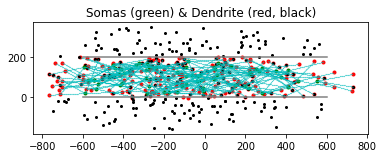

In [18]:
def plot_one_skeleton(soma, pointDend, axes):
    for i in range(pointDend.shape[0]):
        dend_point = pointDend[i, :]
        axes.plot([soma[0], dend_point[0]], [soma[1], dend_point[1]], ':k')

def plot_skeletons(somas, point_dends, axes):
    for s in range(somas.shape[0]):
        soma = somas[s,:2]
        point_dends_1 = point_dends[(s*4):((s+1)*4),:]
        plot_one_skeleton(soma, point_dends_1, axes)
        
figure, axes= plt.subplots(1)

axes.plot(EpointDend[:,0], EpointDend[:,1], 'or', markersize=3)
axes.plot(EpointDendx[:,0], EpointDendx[:,1], 'ok', markersize=2)
axes.plot(somas[:,0],somas[:,1] ,'og', markersize=3)
#plot_skeletons(somas, EpointDend, axes)
axes.plot(xDendAllAll[:], yDendAllAll[:],"oc", markersize=0.1)
    
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas (green) & Dendrite (red, black)");

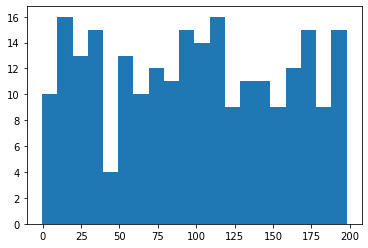

In [19]:
plt.hist(EpointDend[:,1],20);



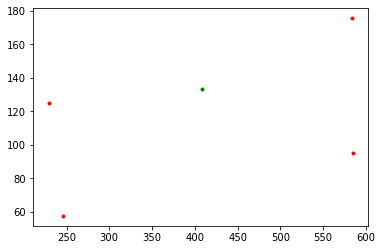

In [20]:
figure, axes= plt.subplots(1)

axes.plot(EpointDend[:4,0], EpointDend[:4,1], 'or', markersize=3)
axes.plot(somas[:1,0],somas[:1,1] ,'og', markersize=3)

## WHAT ABOUT 3D?

In [19]:
#%matplotlib notebook

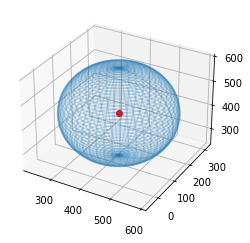

In [22]:
#plotting sphere

phi = np.linspace(0, np.pi, 50)
theta = np.linspace(0, 2*np.pi, 50)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(phi) * np.cos(theta) * Ldend +somas[0,0]
y = np.sin(phi) * np.sin(theta)* Ldend +somas[0,1]
z = np.cos(phi) *Ldend + somas[0,2]


fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, alpha=0.2)
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')
#ax.plot(EpointDendTEST[0,0], EpointDendTEST[0,1], zTest, 'o')
#ax.plot(X1, Y1, Z1, 'ob')


ax.set_aspect("auto")




plt.show()

In [23]:
EpointDendTEST=EpointDend[0:4,:]

In [24]:
EpointDendTEST[0,0]

583.7118684372706

In [25]:
somas[0,0]

408.7758346920775

In [26]:
zTestAll=np.empty((0), dtype=object) #empty array for dendrites
#def pqFormula(Ldend, EpointDendTEST, somas):
for i in range(len(EpointDendTEST)):
    q=(Ldend**2-(EpointDendTEST[i,0]-somas[0,0])**2-(EpointDendTEST[i,1]-somas[0,1])**2)
    root=np.sqrt((somas[0,2])**2-q)
    zTest=np.array(-somas[0,2]+root)
    zTestAll =np.append(zTestAll, zTest, axis=0)




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [27]:
q =(Ldend**2-(EpointDendTEST[0,0]-somas[0,0])**2-(EpointDendTEST[0,1]-somas[0,1])**2)
q

-1.3642420526593924e-12

In [28]:
root=np.sqrt((somas[0,2])**2-q)

In [29]:
zTest=(-somas[0,2]+root)

In [30]:
X1=EpointDendTEST[0,0]
Y1=EpointDendTEST[0,1]
Z1=zTest

In [31]:
dist=((somas[0,0]-X1)**2+(somas[0,1]-Y1)**2+(somas[0,2]-Z1)**2)**0.5

In [32]:
dist

457.77183843134276

In [33]:
zTestAll=np.empty((0), dtype=object) #empty array for dendrites
for i in range(len(phi)):
    zTest=np.array(Ldend*np.cos(phi[i])+somas[0,2])
    zTestAll =np.append(zTestAll, zTest, axis=0)


In [34]:
#how to add x
for i in range(len(EpointDendTEST)):
    #print(EpointDendTEST[i,:])
    #b = np.array([[0],[1],[2],[3]])
    test=np.append(EpointDendTEST,zTestAllTEST, axis=1)

NameError: name 'zTestAllTEST' is not defined

### Random perturbation in z-axis

In [35]:
EpointDend.shape

(240, 2)

In [36]:
from mpl_toolkits.mplot3d import Axes3D

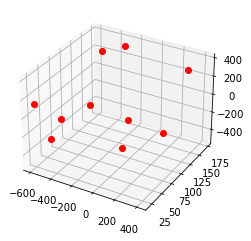

In [37]:
%matplotlib inline
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:10,0], somas[:10,1], somas[:10,2],'or')

In [38]:
EpointDend3 = np.zeros((EpointDend.shape[0], 3))
EpointDend3[:, 0:2] = EpointDend
for i in range(somas.shape[0]):
    EpointDend3[(4*i):(4*(i+1)), 2] = somas[i, 2]

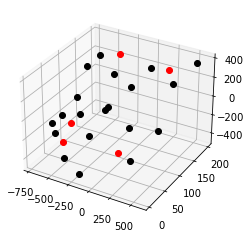

In [39]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:5,0], somas[:5,1], somas[:5,2],'or')
ax.plot(EpointDend3[:20,0], EpointDend3[:20,1], EpointDend3[:20,2],'ok')
#for ii in range(0,360,1):
 #   ax.view_init(elev=5., azim=ii)
  #  plt.savefig("movie_figs/movie%d.png" % ii)

In [40]:
sigma = 24

ep1 = EpointDend[:4,:] - somas[0,:2]
ep1_3d = np.zeros((4,3))
ep1_3d[:,:2] = ep1
ep1_3d[:, 2] = np.random.randn(4)*sigma

# print(ep1_3d)

for i in range(4):
    norm = np.sqrt(ep1_3d[i,0]**2 + ep1_3d[i,1]**2 + ep1_3d[i,2]**2)
    ep1_3d[i,:] = ep1_3d[i,:]/norm*Ldend
   
# print(ep1_3d)
ep1_3d = ep1_3d + somas[0,:]

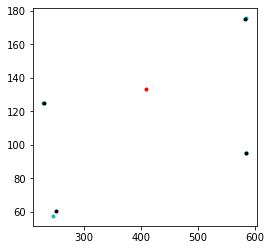

In [41]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111)
ax.plot(somas[0,0], somas[0,1],'.r')
ax.plot(EpointDend[:4,0], EpointDend[:4,1],'.c')
ax.plot(ep1_3d[:,0], ep1_3d[:,1],'.k')


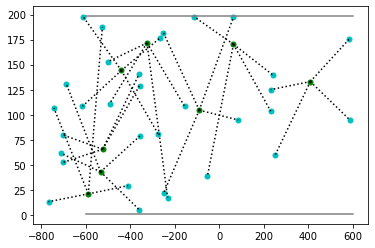

In [84]:
figure, axes= plt.subplots(1)


axes.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], 'oc', markersize=5)
axes.plot(somas[:8,0],somas[:8,1],'og', markersize=5)
plot_skeletons(somas[0:8], ep1_3d_All[0:32], axes)
#axes.plot(xDendAllAll[:], yDendAllAll[:],"oc", markersize=0.1)
    
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")
#plot_skeletons(somas, ep1_3d_All, axes)



In [ ]:
def plot_one_skeleton_3d(soma, ep1_3d_All, axes):
    for i in range(pointDend.shape[0]):
        dend_point = pointDend[i, :]
        axes.plot([soma[0], dend_point[0]], [soma[1], dend_point[1]], ':k')

def plot_skeletons_3d(somas, point_dends, axes):
    for s in range(somas.shape[0]):
        soma = somas[s,:2]
        point_dends_1 = point_dends[(s*4):((s+1)*4),:]
        plot_one_skeleton(soma, point_dends_1, axes)

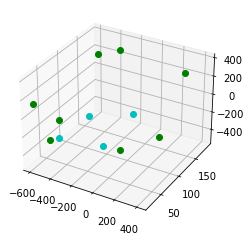

In [89]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0:8,0], somas[0:8,1], somas[0:8,2],'og')
ax.plot(ep1_3d[:32,0], ep1_3d[:32,1], ep1_3d[:32,2],'oc')
plot_skeletons(somas[0:8], ep1_3d_All[0:32], axes)



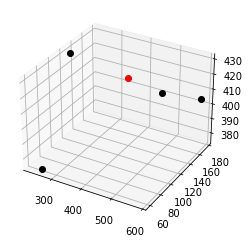

In [43]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')
ax.plot(ep1_3d[:,0], ep1_3d[:,1], ep1_3d[:,2],'ok')

In [44]:
EpointDendTEST=EpointDend[0:8,:]
EpointDendTEST

array([[583.7118684372706, 175.51759854622966],
       [228.95944541677068, 124.99392307794457],
       [245.4816837935535, 57.39211489745677],
       [584.7354468244382, 95.19822774342026],
       [-357.6655801616598, 4.8226058188436625],
       [-690.0272112635811, 132.06625352826825],
       [-712.5881840890117, 61.66418274710627],
       [-357.126275386819, 78.8196876921485]], dtype=object)

In [45]:
ep1_3d_All=np.empty((0,3), dtype=object) #empty array for dendrites

sigma = 24
    
for s in range(somas.shape[0]):
    soma = somas[s,:]

    ep1 = EpointDend[(s*4):((s+1)*4),:] - somas[s,:2]
    ep1_3d = np.zeros((4,3))
    ep1_3d[:,:2] = ep1
    ep1_3d[:, 2] = np.random.randn(4)*sigma

    #print(ep1_3d)

    for i in range(4):
        norm = np.sqrt(ep1_3d[i,0]**2 + ep1_3d[i,1]**2 + ep1_3d[i,2]**2)
        ep1_3d[i,:] = ep1_3d[i,:]/norm*Ldend
    ep1_3d = ep1_3d + somas[s,:]
    ep1_3d_All=np.append(ep1_3d_All, ep1_3d, axis=0)
        #print(EpointDend[(s*4):((s+1)*4),:])

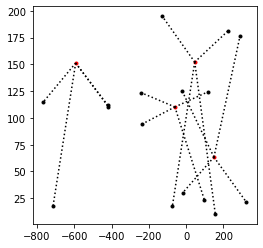

In [97]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111)
for s in range(8,12):
    ax.plot(somas[s,0], somas[s,1],'.r')
    #ax.plot(EpointDend[:,0], EpointDend[:,1],'.c')
    ax.plot(ep1_3d_All[(s*4):((s+1)*4),0], ep1_3d_All[(s*4):((s+1)*4),1],'.k')
    for d in range(4):
        ax.plot([somas[s,0], ep1_3d_All[(s*4+d), 0]],
                [somas[s,1], ep1_3d_All[(s*4+d), 1]], ':k')



100%|██████████| 360/360 [00:43<00:00,  8.26it/s]


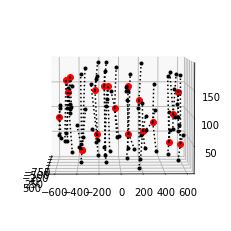

In [106]:
from tqdm import tqdm, trange

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
for s in range(10,30):
    ax.plot(somas[s,0], somas[s,2], somas[s,1], 'or')
    #ax.plot(EpointDend[:,0], EpointDend[:,1],'.c')
    ax.plot(ep1_3d_All[(s*4):((s+1)*4),0], 
            ep1_3d_All[(s*4):((s+1)*4),2],
            ep1_3d_All[(s*4):((s+1)*4),1], '.k')
    for d in range(4):
        ax.plot([somas[s,0], ep1_3d_All[(s*4+d), 0]],
                [somas[s,2], ep1_3d_All[(s*4+d), 2]],
                [somas[s,1], ep1_3d_All[(s*4+d), 1]], ':k')

for ii in trange(0,360,1):
    ax.view_init(elev=5., azim=ii)
    plt.savefig("movie_figs/movie%d.png" % ii)

In [133]:
ep1_3d_All[4:8]

array([[469.7331672107477, 136.49842433934873, -576.5733627378398],
       [114.81130441584023, 139.84297844063994, -576.4299267049956],
       [155.65143472956376, 27.471178724050773, -535.4769559719703],
       [448.46904149023703, 54.5808049412712, -551.8987521096095]],
      dtype=object)

In [134]:
somas[1:2]

array([[ 292.33928492,  144.02050947, -546.99585845]])